In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
import ast

import re
import nltk #Natural Language Toolkit
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from joblib import dump, load

In [72]:
tmdb_5000_movies_df   = pd.read_csv('/content/tmdb_5000_movies.csv', engine='python', on_bad_lines='warn')
tmdb_5000_credits_df  = pd.read_csv('/content/tmdb_5000_credits.csv', engine='python', on_bad_lines='warn')

def Explore(title_, dataframe_):
    display(Markdown(title_))
    display(Markdown('---'))
    display(dataframe_.tail())
    display('Descriptive Statistics')
    display(dataframe_.describe())
    display('Missing Values')
    display(dataframe_.isnull().sum().sort_values(ascending=False))
    display('Column Data Types')
    display(dataframe_.dtypes)

Explore('### Movies Data', tmdb_5000_movies_df)
Explore('### Credits Data', tmdb_5000_credits_df)

### Movies Data

---

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
4798,220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,9367,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238
4799,9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,72766,[],en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],[],2011-12-26,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5
4800,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",http://www.hallmarkchannel.com/signedsealeddel...,231617,"[{""id"": 248, ""name"": ""date""}, {""id"": 699, ""nam...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{""name"": ""Front Street Pictures"", ""id"": 3958}...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2013-10-13,0,120.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,"Signed, Sealed, Delivered",7.0,6
4801,0,[],http://shanghaicalling.com/,126186,[],en,Shanghai Calling,When ambitious New York attorney Sam is sent t...,0.857008,[],"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-05-03,0,98.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,A New Yorker in Shanghai,Shanghai Calling,5.7,7
4802,0,"[{""id"": 99, ""name"": ""Documentary""}]",NaN,25975,"[{""id"": 1523, ""name"": ""obsession""}, {""id"": 224...",en,My Date with Drew,Ever since the second grade when he first saw ...,1.929883,"[{""name"": ""rusty bear entertainment"", ""id"": 87...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2005-08-05,0,90.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,My Date with Drew,6.3,16


'Descriptive Statistics'

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


'Missing Values'

,0
homepage,3091
tagline,844
overview,3
runtime,2
release_date,1
id,0
budget,0
genres,0
original_title,0
popularity,0


'Column Data Types'

,0
budget,int64
genres,object
homepage,object
id,int64
keywords,object
original_language,object
original_title,object
overview,object
popularity,float64
production_companies,object


### Credits Data

---

,movie_id,title,cast,crew
4798,9367,El Mariachi,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de..."
4799,72766,Newlyweds,"[{""cast_id"": 1, ""character"": ""Buzzy"", ""credit_...","[{""credit_id"": ""52fe487dc3a368484e0fb013"", ""de..."
4800,231617,"Signed, Sealed, Delivered","[{""cast_id"": 8, ""character"": ""Oliver O\u2019To...","[{""credit_id"": ""52fe4df3c3a36847f8275ecf"", ""de..."
4801,126186,Shanghai Calling,"[{""cast_id"": 3, ""character"": ""Sam"", ""credit_id...","[{""credit_id"": ""52fe4ad9c3a368484e16a36b"", ""de..."
4802,25975,My Date with Drew,"[{""cast_id"": 3, ""character"": ""Herself"", ""credi...","[{""credit_id"": ""58ce021b9251415a390165d9"", ""de..."


'Descriptive Statistics'

,movie_id
count,4803.000000
mean,57165.484281
std,88694.614033
min,5.000000
25%,9014.500000
50%,14629.000000
75%,58610.500000
max,459488.000000


'Missing Values'

,0
movie_id,0
title,0
cast,0
crew,0


'Column Data Types'

,0
movie_id,int64
title,object
cast,object
crew,object


# Remarks
## Movies Dataframe
### Object Columns
1. Columns genres and keywords are object columns that contains dictionaries bounded within lists i.e. [{'id' : id, 'name' : genre/keyword}] a film can have multiple genres or keywords.
2. homepage contains web adrresses for some of the movies it also has the most missing row values (3091/4803), over 60%.
3. production_companies is an object column that contains dictionaries bounded within lists i.e. [{'name' : production_companies, 'id' : id}] a film can have multiple production_companies.
4. production_countries is an object column that contains dictionaries bounded within lists i.e. [{'iso code' : code letters e.g US, 'name' : production_countries}] a film can have multiple production_countries.
5. release_date is an object column that output the date of release, a good feature for filtering year of release.
6. spoken_languages is an object columns that contains dictionaries bounded within lists i.e. [{'iso code' : code letters e.g US, 'name' : spoken_languages}] a film can have multiple spoken_languages.
7. status is an object column that has 3 unique values i.e ['Released' 'Post Production' 'Rumored']
8. tagline stores individual movie. A tagline is a reiterated phrase identified with an individual, group, or product : slogan. The column also has the second highest missing row values (844/4803), about 18%
9. Title an object columns most likely represents the final title awarded to the movie as welll as original_language and original_title representing the original language and original title
10. overview is the description column for the movie where a brief idea of the movie is illustrated. It has only 3 missing row values (3/4803) only 0.06%

### Float/Int Columns
1. Budget simply stores the movies budget.
2. Popularity stored the popularity ranging from 0 to 876 according to the above dataset.
3. Revenue is simply how much the movie made back.
4. Runtime is movie length in minutes and only has 2 missing row values (2/4803) only 0.04%
5. Vote Average is probably a standardize vote from 0 to 10.
6. Vote Count is the number of people who voted per movie.

## Credits Dataframe
1. Cast is an object columns that contains dictionaries bounded within lists i.e. [{'cast id' : cast_id, 'character' : character's_name, 'credit_id' : unique_float, 'gender' : 0, 'id' : float, 'name' : actors_name, 'order' : int}]
2. Crew is an object column that contains dictionaries bounded within lists i.e. [{"credit_id": "553bef6a9251416874003c8f", "department": "Production", "gender": 2, "id": 3276, "job": "Casting", "name": "Roger Mussenden"}]
3. Movie Id and Title are columns used for reference with the first dataframe.


---
# Data Cleaning

In [73]:
'''
Dropping Homepage and Tagline because they have a significant amount of missing values
Homepage contains web addresses so it may not be as useful.
Tagline is a short quote like statement based on the film, similar information may be present in the overview column.
Will test more in future models.
'''
tmdb_5000_movies_df.drop(['homepage', 'tagline'], axis=1, inplace=True)

In [74]:
'''
Imputing rows with missing data in overview, runtime and release_date since only a small
fraction of the entire column is missing i.e. 0.06%, 0/04% and 0.02% respectively.
'''
tmdb_5000_movies_df.dropna(subset=['overview', 'runtime', 'release_date'], inplace=True)

In [75]:
# Confirm missing values
tmdb_5000_movies_df.isnull().sum()

,0
budget,0
genres,0
id,0
keywords,0
original_language,0
original_title,0
overview,0
popularity,0
production_companies,0
production_countries,0


In [76]:
# Check for duplicates
# tmdb_5000_movies_df[tmdb_5000_movies_df.duplicated()]

---
# Feature Engineering



### Merging tmdb_5000_movies_df and tmdb_5000_credits_df to create cast and crew feature

In [77]:
tmdb_5000_credits_df.rename(columns={"movie_id": "id"}, inplace=True)
tmdb_5000_movies_df.rename(columns={"original_title": "title"}, inplace=True)
print(tmdb_5000_credits_df.columns)
print(tmdb_5000_movies_df.columns)

Index(['id', 'title', 'cast', 'crew'], dtype='object')
Index(['budget', 'genres', 'id', 'keywords', 'original_language', 'title',
       'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'title', 'vote_average', 'vote_count'],
      dtype='object')


In [78]:
tmdb_5000_merged_df = pd.merge(tmdb_5000_movies_df, tmdb_5000_credits_df, how='inner', on='id')
tmdb_5000_merged_df.columns

Index(['budget', 'genres', 'id', 'keywords', 'original_language', 'title_x',
       'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'title_x', 'vote_average', 'vote_count',
       'title_y', 'cast', 'crew'],
      dtype='object')

In [79]:
print(tmdb_5000_merged_df['production_companies'][0])
print(tmdb_5000_merged_df['production_companies'].dtype)

[{"name": "Ingenious Film Partners", "id": 289}, {"name": "Twentieth Century Fox Film Corporation", "id": 306}, {"name": "Dune Entertainment", "id": 444}, {"name": "Lightstorm Entertainment", "id": 574}]
object


### Creating new features; genres_string, keywords_string, cast_string, crew_string, production_company_string and  production_country_string

In [80]:
extraccted_columns = ['keywords', 'genres','cast', 'production_companies', 'production_countries']

tmdb_5000_merged_df['keywords'] = tmdb_5000_merged_df['keywords'].apply(ast.literal_eval)
tmdb_5000_merged_df['genres'] = tmdb_5000_merged_df['genres'].apply(ast.literal_eval)
tmdb_5000_merged_df['cast'] = tmdb_5000_merged_df['cast'].apply(ast.literal_eval)
tmdb_5000_merged_df['production_companies'] = tmdb_5000_merged_df['production_companies'].apply(ast.literal_eval)
tmdb_5000_merged_df['production_countries'] = tmdb_5000_merged_df['production_countries'].apply(ast.literal_eval)

tmdb_5000_merged_df['genres_string'] = tmdb_5000_merged_df['genres'].apply(lambda x: ', '.join([d['name'] for d in x]))
tmdb_5000_merged_df['keywords_string'] = tmdb_5000_merged_df['keywords'].apply(lambda x: ', '.join([d['name'] for d in x]))
tmdb_5000_merged_df['actor_string'] = tmdb_5000_merged_df['cast'].apply(lambda x: ','.join([d['name'] for d in x]))
tmdb_5000_merged_df['cast_string'] = tmdb_5000_merged_df['cast'].apply(lambda x: ','.join([d['character'] for d in x]))
tmdb_5000_merged_df['production_company_string'] = tmdb_5000_merged_df['production_companies'].apply(lambda x: ','.join([d['name'] for d in x]))
tmdb_5000_merged_df['production_country_string'] = tmdb_5000_merged_df['production_countries'].apply(lambda x: ','.join([d['iso_3166_1'] for d in x]))

tmdb_5000_merged_df.head()

,budget,genres,id,keywords,original_language,title_x,overview,popularity,production_companies,production_countries,...,vote_count,title_y,cast,crew,genres_string,keywords_string,actor_string,cast_string,production_company_string,production_country_string
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,11800,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...","Action, Adventure, Fantasy, Science Fiction","culture clash, future, space war, space colony...","Sam Worthington,Zoe Saldana,Sigourney Weaver,S...","Jake Sully,Neytiri,Dr. Grace Augustine,Col. Qu...","Ingenious Film Partners,Twentieth Century Fox ...","US,GB"
1,300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",285,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,4500,Pirates of the Caribbean: At World's End,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...","Adventure, Fantasy, Action","ocean, drug abuse, exotic island, east india t...","Johnny Depp,Orlando Bloom,Keira Knightley,Stel...","Captain Jack Sparrow,Will Turner,Elizabeth Swa...","Walt Disney Pictures,Jerry Bruckheimer Films,S...",US
2,245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",206647,"[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",...,4466,Spectre,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...","Action, Adventure, Crime","spy, based on novel, secret agent, sequel, mi6...","Daniel Craig,Christoph Waltz,Léa Seydoux,Ralph...","James Bond,Blofeld,Madeleine,M,Lucia,Q,Moneype...","Columbia Pictures,Danjaq,B24","GB,US"
3,250000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",49026,"[{'id': 849, 'name': 'dc comics'}, {'id': 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,9106,The Dark Knight Rises,"[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...","Action, Crime, Drama, Thriller","dc comics, crime fighter, terrorist, secret id...","Christian Bale,Michael Caine,Gary Oldman,Anne ...","Bruce Wayne / Batman,Alfred Pennyworth,James G...","Legendary Pictures,Warner Bros.,DC Entertainme...",US
4,260000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",49529,"[{'id': 818, 'name': 'based on novel'}, {'id':...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",...,2124,John Carter,"[{'cast_id': 5, 'character': 'John Carter', 'c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...","Action, Adventure, Science Fiction","based on novel, mars, medallion, space travel,...","Taylor Kitsch,Lynn Collins,Samantha Morton,Wil...","John Carter,Dejah Thoris,Sola,Tars Tarkas,Tal ...",Walt Disney Pictures,US


Perform transformations on the data

In [81]:
# Columns to transform.
columns_to_lower = ['overview', 'genres_string', 'keywords_string', 'cast_string', 'actor_string', 'production_company_string', 'production_country_string']

# Convert training data samples to lowercase and using regex to remove special characters.
# 'map' applies the function to individual cells.
for col in columns_to_lower:
    tmdb_5000_merged_df[col] = tmdb_5000_merged_df[col].map(lambda x: x.lower() if isinstance(x, str) else x)
    tmdb_5000_merged_df[col] = tmdb_5000_merged_df[col].map(lambda x: re.sub(r'[^a-zA-Z\s]', ' ', x))

tmdb_5000_merged_df.head()

,budget,genres,id,keywords,original_language,title_x,overview,popularity,production_companies,production_countries,...,vote_count,title_y,cast,crew,genres_string,keywords_string,actor_string,cast_string,production_company_string,production_country_string
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,in the nd century a paraplegic marine is di...,150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,11800,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",action adventure fantasy science fiction,culture clash future space war space colony...,sam worthington zoe saldana sigourney weaver s...,jake sully neytiri dr grace augustine col qu...,ingenious film partners twentieth century fox ...,us gb
1,300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",285,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,captain barbossa long believed to be dead ha...,139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,4500,Pirates of the Caribbean: At World's End,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",adventure fantasy action,ocean drug abuse exotic island east india t...,johnny depp orlando bloom keira knightley stel...,captain jack sparrow will turner elizabeth swa...,walt disney pictures jerry bruckheimer films s...,us
2,245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",206647,"[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",en,Spectre,a cryptic message from bond s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",...,4466,Spectre,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",action adventure crime,spy based on novel secret agent sequel mi ...,daniel craig christoph waltz l a seydoux ralph...,james bond blofeld madeleine m lucia q moneype...,columbia pictures danjaq b,gb us
3,250000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",49026,"[{'id': 849, 'name': 'dc comics'}, {'id': 853,...",en,The Dark Knight Rises,following the death of district attorney harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,9106,The Dark Knight Rises,"[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",action crime drama thriller,dc comics crime fighter terrorist secret id...,christian bale michael caine gary oldman anne ...,bruce wayne batman alfred pennyworth james g...,legendary pictures warner bros dc entertainme...,us
4,260000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",49529,"[{'id': 818, 'name': 'based on novel'}, {'id':...",en,John Carter,john carter is a war weary former military ca...,43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",...,2124,John Carter,"[{'cast_id': 5, 'character': 'John Carter', 'c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",action adventure science fiction,based on novel mars medallion space travel ...,taylor kitsch lynn collins samantha morton wil...,john carter dejah thoris sola tars tarkas tal ...,walt disney pictures,us


In [82]:
# Download stopwords onto ram
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

tmdb_5000_merged_df['overview'] = tmdb_5000_merged_df['overview'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
tmdb_5000_merged_df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,budget,genres,id,keywords,original_language,title_x,overview,popularity,production_companies,production_countries,...,vote_count,title_y,cast,crew,genres_string,keywords_string,actor_string,cast_string,production_company_string,production_country_string
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,nd century paraplegic marine dispatched moon p...,150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,11800,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",action adventure fantasy science fiction,culture clash future space war space colony...,sam worthington zoe saldana sigourney weaver s...,jake sully neytiri dr grace augustine col qu...,ingenious film partners twentieth century fox ...,us gb
1,300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",285,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,captain barbossa long believed dead come back ...,139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,4500,Pirates of the Caribbean: At World's End,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",adventure fantasy action,ocean drug abuse exotic island east india t...,johnny depp orlando bloom keira knightley stel...,captain jack sparrow will turner elizabeth swa...,walt disney pictures jerry bruckheimer films s...,us
2,245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",206647,"[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",en,Spectre,cryptic message bond past sends trail uncover ...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",...,4466,Spectre,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",action adventure crime,spy based on novel secret agent sequel mi ...,daniel craig christoph waltz l a seydoux ralph...,james bond blofeld madeleine m lucia q moneype...,columbia pictures danjaq b,gb us
3,250000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",49026,"[{'id': 849, 'name': 'dc comics'}, {'id': 853,...",en,The Dark Knight Rises,following death district attorney harvey dent ...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,9106,The Dark Knight Rises,"[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",action crime drama thriller,dc comics crime fighter terrorist secret id...,christian bale michael caine gary oldman anne ...,bruce wayne batman alfred pennyworth james g...,legendary pictures warner bros dc entertainme...,us
4,260000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",49529,"[{'id': 818, 'name': 'based on novel'}, {'id':...",en,John Carter,john carter war weary former military captain ...,43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",...,2124,John Carter,"[{'cast_id': 5, 'character': 'John Carter', 'c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",action adventure science fiction,based on novel mars medallion space travel ...,taylor kitsch lynn collins samantha morton wil...,john carter dejah thoris sola tars tarkas tal ...,walt disney pictures,us


---
### Vectorizer

$$
TF(w) = \frac{\text{Number of times w appears in d}}{\text{Total number of words in d}}
$$
where :
- w is word
- d is document(sample)
$$
IDF(w) = \log({\frac{N}{\text{DF}(w)}+1})
$$
where :
- N = Total number of documents(samples)
- DF(w) = Number of documents that contain w
- Adding 1 in the denominator prevents division by zero

$$
TFIDF(w,d) = TF(w,d) * (\text{IDF}(w))
$$

- Implementation of the above formulas can differ based on how the TfidfVectorizer is intialized accounting for smoothing, normalization etc.

In [83]:
tmdb_5000_merged_df['combined_text'] = tmdb_5000_merged_df[['overview', 'genres_string', 'keywords_string', 'cast_string', 'actor_string', 'production_company_string', 'production_country_string']].apply(lambda x: ' '.join(x.dropna()), axis=1)
print(tmdb_5000_merged_df['combined_text'][1])

captain barbossa long believed dead come back life headed edge earth turner elizabeth swann nothing quite seems adventure  fantasy  action ocean  drug abuse  exotic island  east india trading company  love of one s life  traitor  shipwreck  strong woman  ship  alliance  calypso  afterlife  fighter  pirate  swashbuckler  aftercreditsstinger captain jack sparrow will turner elizabeth swann william  bootstrap bill  turner captain sao feng captain davy jones captain hector barbossa admiral james norrington joshamee gibbs lord cutler beckett tia dalma governor weatherby swann captain teague sparrow pintel ragetti lieutenant theodore groves cotton marty ian mercer scarlett giselle mullroy murtogg tai huang henry turner mistress ching lieutenant greitzer hadras clacker penrod cotton s parrot  voice  captain teague captain jocard captain ammand johnny depp orlando bloom keira knightley stellan skarsg rd chow yun fat bill nighy geoffrey rush jack davenport kevin mcnally tom hollander naomie har

In [84]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(tmdb_5000_merged_df['combined_text'])

In [85]:
# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Convert the matrix to a readable format
# tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
print(feature_names)

['aa' 'aaa' 'aachen' ... 'zyler' 'zylka' 'zylowski']


In [86]:
tfidf_matrix.shape

(4799, 71669)

---
# Machine Learning
## Clustering using KMeans (Unsupervised Learning)
- To calculate intra-cluster distance I'll be using interia which essentially calculates the square sum of the distance between each point in a cluster and the centroid of the cluster
$$
\text{inertia} = \sum_{i=1}^{K}\sum_{xj \in C_i} \left\| x_j - \mu_i \right\|^2
$$
Where
  - $K$ is Number of clusters
  - $C_i$ is cluster $i$
  - $x_j$ is data point assigned to cluster $i$
  - $\mu_i$ is the centroid of cluster i
  - $\left\| x_j - \mu_i \right\|^2$ is squared Euclidean distance between point and cluster center
- To calculate how well a data point fits to its cluster I'll use the silhouettte score which measures the relationship between a data point in cluster $C_i$ to every other cluster
### Average intra-cluster distance
$$
\text{a(c)} = \frac{1}{\left\|C_i \right\| - 1}\sum_{y \in C_i, y \neg x} \left\| x - y\right\|
$$
  - $C_i$ is the cluster containing the point x
  - $\left|C_i \right|$ is the number of points in clister i
  - $\left\| x - y \right\|$ is the distance between points x and another point y in the same clsuter
  - The sum iterates over all points in $C_i$, excluding $x$ itself.
  - The fraction normalizes the sum by the number of points in the cluster (excluding $x$).
### Average inter-cluster distnace
$$
\text{b(x)} = \min_{J \neg i}\frac{1}{\left| C_j \right|}\sum_{y \in C_j}\left\| x - y \right\|
$$  
  - The minimum is taken over all clusters $C_j$ where $j \neg i$
  - $\left|C_j \right|$ is the number of points in clister j  
  - The sum iterates over all points in cluster $C_j$, computing the average distance to $x$
  - The cluster $C_j$ that gives the minimum value is considered the "nearest" cluster.
### Silhouette score for x
$$
\text{s(x)} = \frac{\text{b(x) - a(x)}}{\max{\text{(a(x),b(x))}}}
$$
This measures how well $x$ is clustered:
Where
- If $s(x)$ is close to 1, the point is well clustered.
- If $s(x)$ is close to 0, the point is on the boundary between two clusters.
- If $s(x)$ is negative, the point is likely misclassified.


### Initialize Variables

In [87]:
silhouette_dataframe = pd.DataFrame(columns=['Model', 'Silhouette Score', 'Clusters'])

### K Means

In [88]:
# Intialize a list for inertia
k_cluster_inertia = []

# Loop through 50 clusters
for i in range(1,51):
    kmeans_range     = KMeans(n_clusters=i, random_state=42)
    kmeans_range.fit(tfidf_matrix)
    k_cluster_inertia.append(kmeans_range.inertia_)

In [89]:
# Store Interia values using joblib to compare later with lower dimension data
dump(k_cluster_inertia, 'K-cluster-ineria-high-dimensionality')

['K-cluster-ineria-high-dimensionality']

In [90]:
# # Trained in google colab
# k_cluster_inertia = load('/content/K-cluster-ineria-high-dimensionality')

<function matplotlib.pyplot.show(close=None, block=None)>

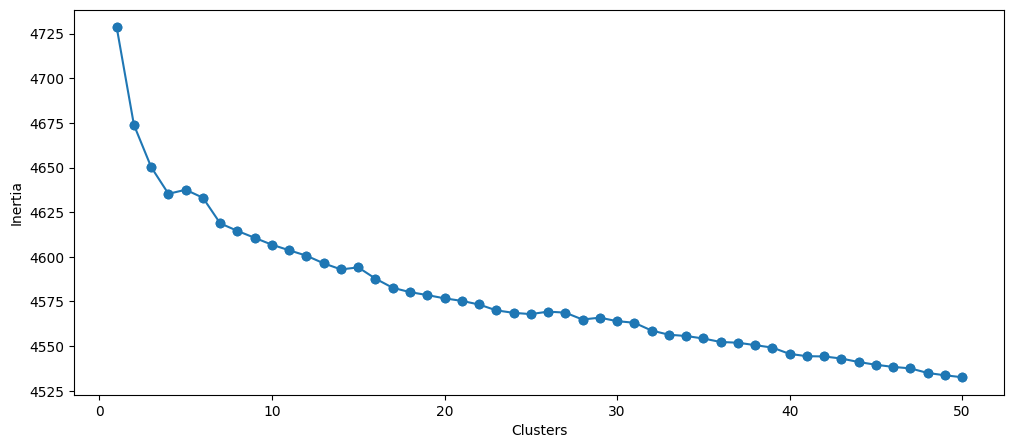

In [91]:
high_dimensional_kmeans = pd.DataFrame({'Clsuters' : range(1,51), 'Inertia' : k_cluster_inertia})

plt.figure(figsize=(12,5))
plt.scatter(x=high_dimensional_kmeans['Clsuters'], y=high_dimensional_kmeans['Inertia'])
plt.plot(high_dimensional_kmeans['Clsuters'], high_dimensional_kmeans['Inertia'], marker='o')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.show


In [92]:
kmean_hd_labels = KMeans(n_clusters=5, random_state=42).fit_predict(tfidf_matrix)
dump(kmean_hd_labels, 'kmean_hd_labels')

['kmean_hd_labels']

In [93]:
# kmean_hd_labels = load('/content/kmean_hd_labels')

In [94]:
# Calculating silhouette score
silhouette_score_high_dimensionality = silhouette_score(tfidf_matrix, kmean_hd_labels)

# Create a new row for K Means with high dimensionality
kmeans_high_dimensionality_row = pd.DataFrame({'Model' : ['KMeans Hd'], 'Silhouette Score' : [silhouette_score_high_dimensionality], 'Clusters' : [5]})

# Add row to dataframe
silhouette_dataframe = pd.concat([silhouette_dataframe, kmeans_high_dimensionality_row], ignore_index=True)
silhouette_dataframe.head(10)

<ipython-input-94-ae1f8812409f>:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  silhouette_dataframe = pd.concat([silhouette_dataframe, kmeans_high_dimensionality_row], ignore_index=True)


,Model,Silhouette Score,Clusters,Cluster
0,KMeans Hd,0.006366,NaN,5.0


---
# Principal Component Analysis
This is a dimensionality reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set. This increases simplicity but we trade a little be of accuracy by doing this, however PCA decorrelates features, keeps only the most informative features and filters out noise hence increasing stability.
- Step 1 is standardization, since we don't want different scales from different features having dominance over features with smaller scales.
- Step 2 is computing the covariance Matrix in order to see the relationships between different features.
- Step 3 is computing the eigenvalues and eigenvectors
$$
C v_i = \lambda_i v_i
$$
  - $v_i$ (eigenvectors): this are the principal component directions
  - $\lambda_i$ (eigenvalues): variance explained by each principal component
  - Each of the 1000 original variables contributes some weight to each eigenvector.
- Step 4: Sort and select top $k$ principal components
  - Sort eigenvectors by decreasing eigenvalues.
  - Select the top $k$ eigenvectors that explain the most variance.
- Step 5: Transform the data
  - Finally, project the original data onto the new $k$ dimensional subspace
  $$
  X_{reduced} = XW
  $$
  - X is the original n * 1000 data matrix
  - W is the 1000 * 2 matrix containing the top 2 eigenvectors
  - $X_{reduced}$ is the n * 2 matrix containg the new 2D coordinates
- `Intuitively` think of your dataset as a cloud of points in a high-dimensional space. Each point represents a data sample, and the goal of PCA is to find the best lower-dimensional representation of this cloud while preserving as much of its shape (variance) as possible.

In [95]:
# Step 1: Fit PCA to find the optimal number of components
pca_100 = PCA(n_components=100)
tfidf_pca_100 = pca_100.fit_transform(tfidf_matrix.toarray())

In [96]:
dump(tfidf_pca_100, 'tfidf_pca_100')
dump(pca_100, 'pca_100')

['pca_100']

In [97]:
# tfidf_pca_100 = load('/content/tfidf_pca_100')
# pca_100 = load('/content/pca_100')

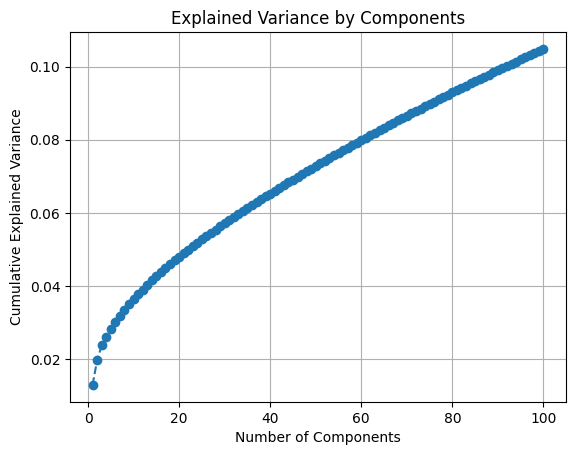

In [98]:
# Cumulative sum of explained variance
explained_variance = np.cumsum(pca_100.explained_variance_ratio_)

# Plot cumulative explained variance
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by Components")
plt.grid()
plt.show()

In [99]:
# Step 1: Fit PCA to find the optimal number of components
pca_2 = PCA(n_components=2)
tfidf_pca_2 = pca_2.fit_transform(tfidf_matrix.toarray())

In [100]:
dump(tfidf_pca_2, 'tfidf_pca_2')

['tfidf_pca_2']

In [101]:
# tfidf_pca_2 = load('/content/tfidf_pca_2')

In [102]:
# Intialize a list for inertia
k_cluster_inertia_low_dimensionality = []

# Loop through 10 clusters
for i in range(1,16):
    kmeans_range     = KMeans(n_clusters=i, random_state=42)
    kmeans_range.fit(tfidf_pca_2)
    k_cluster_inertia_low_dimensionality.append(kmeans_range.inertia_)

In [103]:
# Store Interia values using joblib to compare later with lower dimension data
dump(k_cluster_inertia_low_dimensionality, 'K-cluster-ineria-low-dimensionality')

['K-cluster-ineria-low-dimensionality']

In [104]:
# k_cluster_inertia_low_dimensionality = load('/content/K-cluster-ineria-low-dimensionality')

<function matplotlib.pyplot.show(close=None, block=None)>

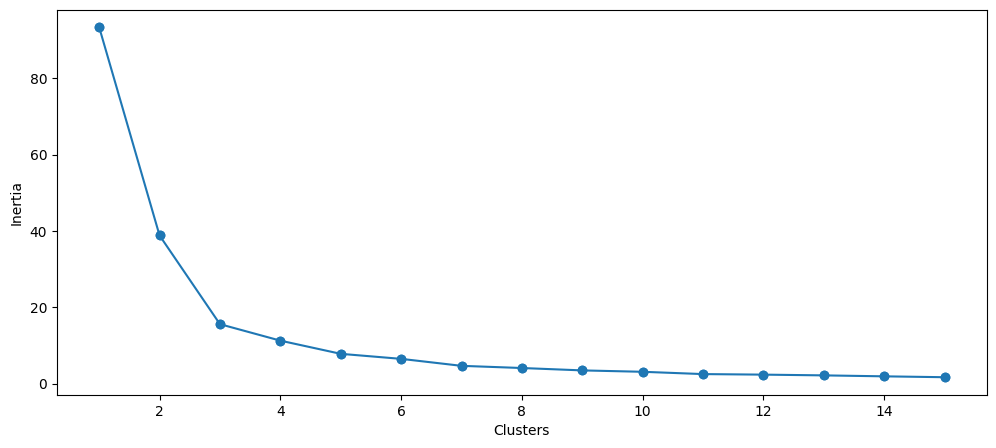

In [105]:
low_dimensional_kmeans = pd.DataFrame({'Clsuters' : range(1,16), 'Inertia' : k_cluster_inertia_low_dimensionality})

plt.figure(figsize=(12,5))
plt.scatter(x=low_dimensional_kmeans['Clsuters'], y=low_dimensional_kmeans['Inertia'])
plt.plot(low_dimensional_kmeans['Clsuters'], low_dimensional_kmeans['Inertia'], marker='o')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.show


In [106]:
# Training and predicting using Kmeans after PCA
kmeans_ld_labels = KMeans(n_clusters=5, random_state=42).fit_predict(tfidf_pca_2)
dump(kmeans_ld_labels, 'kmeans_ld_labels')

['kmeans_ld_labels']

In [107]:
# kmeans_ld_labels = load('/content/kmeans_ld_labels')

In [108]:
# Calculating silhouette score
silhouette_score_low_dimensionality = silhouette_score(tfidf_pca_2, kmeans_ld_labels)

new_row = pd.DataFrame({'Model' : ['KMeans Ld'], 'Silhouette Score' : [silhouette_score_low_dimensionality], 'Clusters' : [5]})
silhouette_dataframe = pd.concat([silhouette_dataframe, new_row], ignore_index=True)
silhouette_dataframe.head(10)

,Model,Silhouette Score,Clusters,Cluster
0,KMeans Hd,0.006366,NaN,5.0
1,KMeans Ld,0.788097,NaN,5.0


---
# Gaussian Mixture Models
Gaussian mixture models are a probabilistic model for representing normally distributed subpopulations within an overall population. Mixture models in general don't require knowing which subpopulation a data point belongs to, allowing the model to learn the subpopulations automatically. Since subpopulation assignment is not known, this constitutes a form of unsupervised learning.

### One Dimensional Model
$$
P(x) = \sum_{i=1}^{K}ΦN(x \mid \mu_i, \sigma_i)
$$
- This means that the probability of $x$ is modeled as a weighted sum of multiple normal distributions.
- $K$ is the number of Gaussian components (clusters).
- $Φ$ is the weight of each Gaussian (sum of all $\phi$ values is 1).
- $N(x \mid \mu_i, \sigma_i)$ is a normal (Gaussian) distribution with mean $\mu$ and standard deviation $σ$
$$
N(x \mid \mu_i, \sigma_i) = \frac{1}{\sqrt{2 \pi \sigma_i^2}} \exp\left(-\frac{(x - \mu_i)^2}{2 \sigma_i^2}\right)
$$
This formula represents a normal distribution, where:

- $\frac{1}{\sqrt{2 \pi \sigma_i^2}}$ is a scaling factor that ensures the total probability sums to 1.
- $\exp\left(-\frac{(x - \mu_i)^2}{2 \sigma_i^2}\right)$ gives the probability density of $x$ being near $\mu_i$, with a higher probability for values close to $\mu_i$
  - If $x$ is close to $\mu_i$ the exponent is small, meaning $exp^x$ is close to 1, so the probability is high.
  - If $x$ is far from $\mu_i$ the exponent is large and negative, making $exp^x$ lose to 0, so the probability is low.
$$
P(x) = \sum_{i=1}^{K}\phi_i\frac{1}{\sqrt{2 \pi \sigma_i^2}} \exp\left(-\frac{(x - \mu_i)^2}{2 \sigma_i^2}\right)
$$
- The final probability density of $x$ is the sum of multiple Gaussian components.
- Each Gaussian is weighted by $\phi$, meaning some clusters contribute more than others.
- If $K=1$, this reduces to a single Gaussian distribution.

### Multi Dimensional Model
$$
P(x) = \sum_{i=1}^{K}ΦN(x \mid \mu_i, \Sigma)
$$
- Here instead of variance we use the covariance $\Sigma$ (measures how two variables change together)
$$
p(x) = \sum_{i=1}^{K} \phi_i \mathcal{N}(x \mid \mu_i, \Sigma_i) = \sum_{i=1}^{K} \phi_i \frac{1}{(2\pi)^{K/2} |\Sigma_i|^{1/2}} \exp\left( -\frac{1}{2} (x - \mu_i)^T \Sigma_i^{-1} (x - \mu_i) \right)
$$
It expresses the probability $p(x)$ of a data point $x$ being generated by a mixture of multiple Gaussian distributions.
- $(x - \mu_i)^T \Sigma_i^{-1} (x - \mu_i)$ This expression represents the Mahalanobis distance, which measures how far a point $x$ is from the mean $\mu_i$, while accounting for correlations in the data, this is because in multiple dimensions, different variables may have different scales and correlations hence euclidian distance would having some incnsistencies.

### Learning the Model
Expectation Maximization (EM) is an iterative algorithm used to estimate parameters in probabilistic models, especially when data has missing or hidden variables (latent variables).
- In the E-step, we calculate the probability that each data point $x_i$ belongs to a specific cluster $C_k$, given the current estimates of the model parameters $\phi_k, \mu_k \text{ and } \sigma_k$, the first iteration of variables is choosen using random selection methods.
$$
P(C_k \mid x_i) = \frac{\phi_kN(x_i \mid \mu_k, \sigma_k)}{\sum_{j=1}^{K}\phi_jN(x_i \mid \mu_j, \sigma_j)}
$$
  - $P(C_k \mid x_i)$ : The posterior probability that data point $x_i$
  belongs to cluster $k$
  - $\phi_k$ : The weight (prior probability) of cluster $k$, representing how much of the total data belongs to this cluster.
  - $N(x_i \mid \mu_k, \sigma_k)$ : The probability density function (PDF) of the normal distribution for cluster $k$ evaluated at $x_i$ This describes how likely $x_i$ is under that Gaussian distribution.
  - The denominator: This sums over all $K$ clusters, ensuring the probability is normalized (i.e., sums to 1 across all clusters).
  - `Intuitively` The numerator calculates the probability of observing $x_i$ in cluster $k$, weighted by how much we expect data to belong to that cluster (i.e.,$\phi_k$) and The denominator ensures that the probability is properly scaled, considering contributions from all $K$ clusters.
- In the M-Step we update the model parameters by maximizing the likelihood of the data
- A likelihood function (often simply called the likelihood) measures how well a statistical model explains observed data by calculating the probability of seeing that data under different parameter values of the model.
$$
\phi_k = \frac{1}{N}\sum_{i=1}^{N}P(C_k \mid x_i)
$$
  - $\phi_k$: The new estimated proportion of data points that belong to cluster $k$
  - $N$: The total number of data points.
  - $P(C_k \mid x_i)$: The probability that data point $x_i$ belongs to cluster $k$ (computed in the E-step).
  - Sum over all data points: We add up the probabilities for every $x_i$ in the dataset, then divide by $N$ to get the average.
  - `Intuitively` If many points have a high probability of belonging to cluster $k$, then $\phi_k$ will be large, If few points belong to cluster $k$, then $\phi_k$ will be small.
$$
\mu_k = \frac{\sum_{i=1}^NP(C_k \mid x_i)x_i}{\sum_{i=1}^NP(C_k \mid x_i)}
$$
  - Each data point $x_i$ contributes to the new mean, but its contribution is weighted by how likely it is to belong to cluster $k$, If a point is very likely to be in cluster $k$, it has a higher weight in the sum.
  - The denominator ensures the mean is properly scaled by the total probability mass for cluster $k$
  - `Intuitively` It updates $\mu_k$ as the average location of points weighted by their likelihood of belonging to cluster $k$, This means the new mean moves closer to the points that are more strongly associated with that cluster.
$$
\sigma_k^2 = \frac{\sum_{i=1}^NP(C_k \mid x_i)(x_i - \mu_k)^2}{\sum_{i=1}^NP(C_k \mid x_i)}
$$
  - Each data point contributes to the variance based on how far it is from the mean $\mu_k$, weighted by how likely it is to belong to cluster $k$
  - The denominator ensures the variance is properly scaled by the total probability mass for cluster $k$
  - `Intuitively` It updates $\sigma_k^2$ as the average squared distance from the mean, but gives more weight to points that are strongly associated with the cluster.

In [109]:
n_clusters = range(1, 10)  # Try different cluster numbers
bic_scores = []
aic_scores = []

for k in n_clusters:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(tfidf_pca_2)
    bic_scores.append(gmm.bic(tfidf_pca_2))
    aic_scores.append(gmm.aic(tfidf_pca_2))

# Find the best number of clusters
best_k_bic = n_clusters[np.argmin(bic_scores)]
best_k_aic = n_clusters[np.argmin(aic_scores)]

print(f"Best number of clusters (BIC): {best_k_bic}")
print(f"Best number of clusters (AIC): {best_k_aic}")

dump(bic_scores, 'bic_scores')
dump(aic_scores, 'aic_scores')

Best number of clusters (BIC): 9
Best number of clusters (AIC): 9


['aic_scores']

In [110]:
# bic_scores = load('/content/bic_scores')
# aic_scores = load('/content/aic_scores')

Text(0, 0.5, 'BIC')

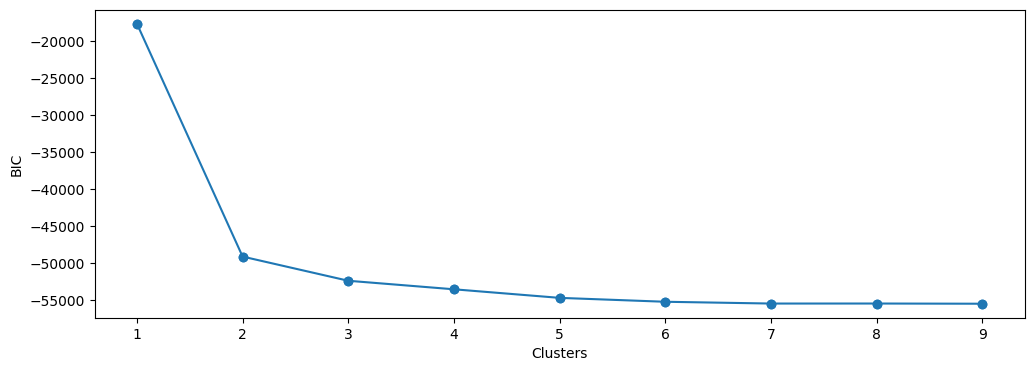

In [111]:
gmm_bic_scores = pd.DataFrame({'Clsuters' : range(1,10), 'BIC' : bic_scores})

plt.figure(figsize=(12,4))
plt.scatter(x=gmm_bic_scores['Clsuters'], y=gmm_bic_scores['BIC'])
plt.plot(gmm_bic_scores['Clsuters'], gmm_bic_scores['BIC'], marker='o')
plt.xlabel('Clusters')
plt.ylabel('BIC')

Text(0, 0.5, 'BIC')

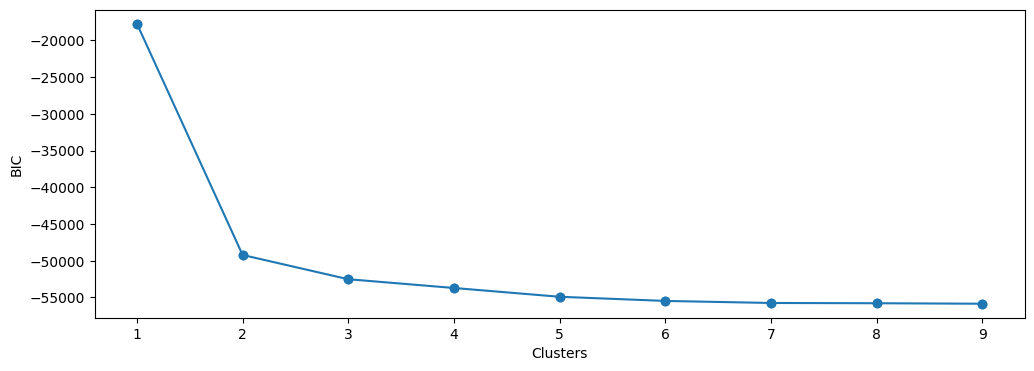

In [112]:
gmm_aic_scores = pd.DataFrame({'Clsuters' : range(1,10), 'BIC' : aic_scores})

plt.figure(figsize=(12,4))
plt.scatter(x=gmm_aic_scores['Clsuters'], y=gmm_aic_scores['BIC'])
plt.plot(gmm_aic_scores['Clsuters'], gmm_aic_scores['BIC'], marker='o')
plt.xlabel('Clusters')
plt.ylabel('BIC')

In [136]:
gmm_pca        = GaussianMixture(n_components=9, random_state=42).fit(tfidf_pca_2)
gmm_pca_labels = gmm_pca.predict(tfidf_pca_2)
dump(gmm_pca, 'gmm_pca')
dump(gmm_pca_labels, 'gmm_pca_labels')

['gmm_pca_labels']

In [114]:
# gmm_pca        = load('/content/gmm_pca')
# gmm_pca_labels = load('/content/gmm_pca_labels')

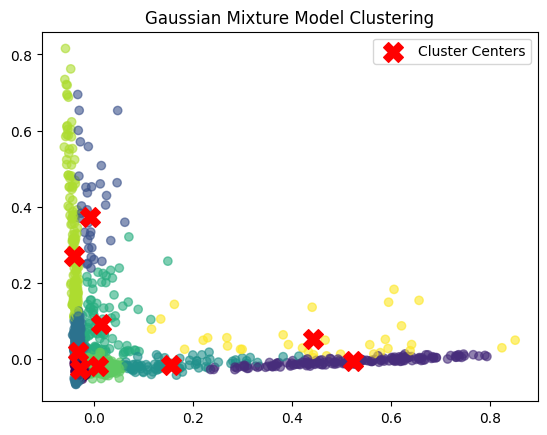

In [137]:
plt.scatter(tfidf_pca_2[:, 0], tfidf_pca_2[:, 1], c=gmm_pca_labels, cmap='viridis', alpha=0.6)
plt.scatter(gmm_pca.means_[:, 0], gmm_pca.means_[:, 1], c='red', marker='X', s=200, label='Cluster Centers')
plt.title("Gaussian Mixture Model Clustering")
plt.legend()
plt.show()


In [116]:
score = silhouette_score(tfidf_pca_2, gmm_pca_labels)

new_row = pd.DataFrame({'Model' : ['GMM'], 'Silhouette Score' : [score], 'Clusters' : [6]})

silhouette_dataframe = pd.concat([silhouette_dataframe, new_row], ignore_index=True)
silhouette_dataframe.head(20)

,Model,Silhouette Score,Clusters,Cluster
0,KMeans Hd,0.006366,NaN,5.0
1,KMeans Ld,0.788097,NaN,5.0
2,GMM,0.581286,NaN,6.0


---
# Heirarchical Clustering

In [117]:
hc_labels = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward').fit_predict(tfidf_pca_2)
dump(hc_labels, 'hc_labels')

['hc_labels']

In [118]:
# hc_labels = load('/content/hc_labels')

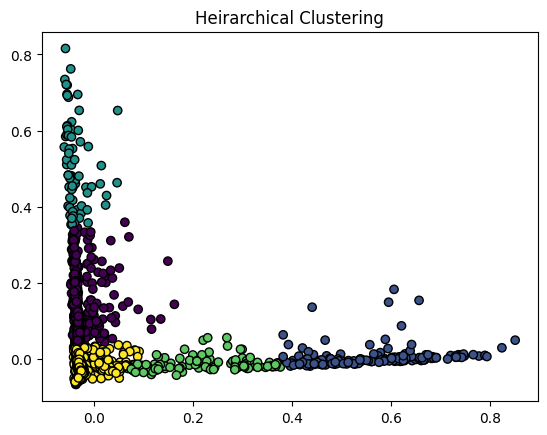

In [119]:
plt.scatter(tfidf_pca_2[:, 0], tfidf_pca_2[:, 1], c=hc_labels, cmap='viridis', edgecolor='k')
plt.title("Heirarchical Clustering")
plt.show()

In [120]:
hc_score = silhouette_score(tfidf_pca_2, hc_labels)

new_row = pd.DataFrame({'Model' : ['HC'], 'Silhouette Score' : [hc_score], 'Clusters' : [5]})

silhouette_dataframe = pd.concat([silhouette_dataframe, new_row], ignore_index=True)
silhouette_dataframe.head(10)

,Model,Silhouette Score,Clusters,Cluster
0,KMeans Hd,0.006366,NaN,5.0
1,KMeans Ld,0.788097,NaN,5.0
2,GMM,0.581286,NaN,6.0
3,HC,0.784536,NaN,5.0


---
# DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
DBSCAN groups points into clusters based on density, defining dense regions as clusters and marking sparse regions as noise.

1. Key Parameters
  - $\epsilon$(eps)-> Defines the neighborhood radius around a point.
  - $\textit{MinPts}$ -> Minimum number of points required to form a dense region.
2. Core Concepts
  - Reachilibilty and Neighborhood <br>
  For a point $p$, define its $ϵ$-neighbourhood as:
  $$
  N_ϵ(P) = \{q \in D \mid d(p,q) \leq \varepsilon \}
  $$
  - Point Classification <br>
  Each point in the dataset is classified as:
    1. Core point: If $\mid N_ɛ(P) \mid \geq \textit{MinPts}$, meaning the point has enough neighbors.
    2. Border Point: Lies within $ϵ$-distance of a core point but has fewer than $\textit{MinPts} neighbors$
    3. Noise (Outlier) Point: Neither a core nor a border point.
3. Density Reachability.
  - A point $q$ is directly density-reachable from p if: <br>
  $q \in N_ϵ(P)$ and $\mid N_ϵ(P) \mid \geq \textit{MinPts}$ <br>
  Meaning a point $q$ is within the radius of the core, $p$ defined by radius $ϵ$ and the core encompases enough points to be considered a core.
  - A point $q$ is density-reachable from $p$ if there exist a chain of core points $P1, P2, ..., Pn$ <br>
  Meaning that a point $q$ is within a chain of clusters linked via making more cores that connect more points this is done to create dense areas that aren't sperical in nature essentially uncovering unique points and identfying outliers.
4. Density Connectivity.
- Two points $p$ and $q$ are density-connected if there exists a third point $o$ (a core point) such that both $p$ and $q$ are density-reachable from $o$.
- Ensures clusters remain globally connected, even if some points are not directly linked but are part of the same dense region.

    



In [121]:
dbscan_labels = DBSCAN(eps=0.06, min_samples=3).fit_predict(tfidf_pca_2)  # Set parameters, fit model and get cluster labels
dump(dbscan_labels, 'dbscan_labels')

['dbscan_labels']

In [122]:
# dbscan_labels = load('/content/dbscan_labels')

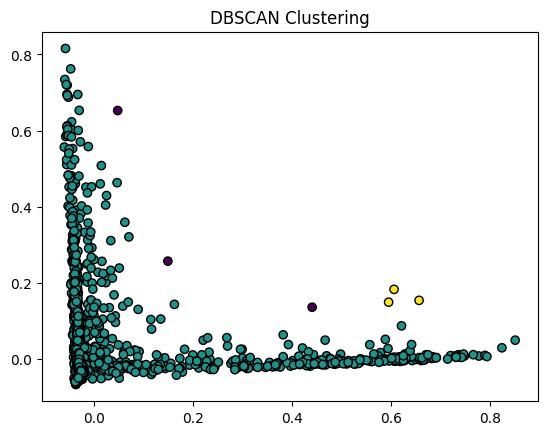

In [123]:
plt.scatter(tfidf_pca_2[:, 0], tfidf_pca_2[:, 1], c=dbscan_labels, cmap='viridis', edgecolor='k')
plt.title("DBSCAN Clustering")
plt.show()

In [124]:
dbscan_score = silhouette_score(tfidf_pca_2, dbscan_labels)

new_row = pd.DataFrame({'Model' : ['DBSCAN'], 'Silhouette Score' : [dbscan_score], 'Clusters' : [6]})

silhouette_dataframe = pd.concat([silhouette_dataframe, new_row], ignore_index=True)
silhouette_dataframe.head(20)

,Model,Silhouette Score,Clusters,Cluster
0,KMeans Hd,0.006366,NaN,5.0
1,KMeans Ld,0.788097,NaN,5.0
2,GMM,0.581286,NaN,6.0
3,HC,0.784536,NaN,5.0
4,DBSCAN,0.771743,NaN,6.0


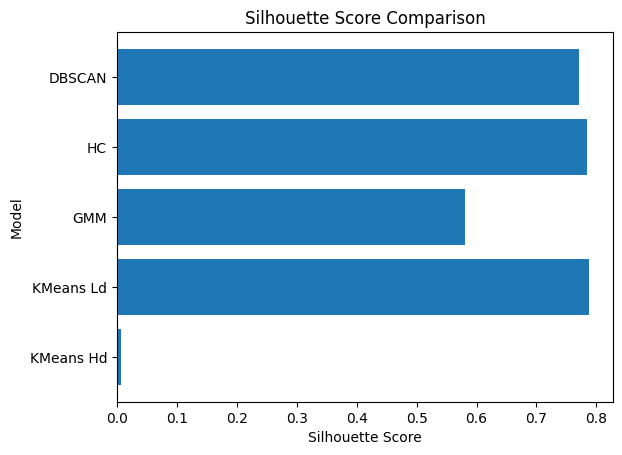

In [125]:
plt.barh(silhouette_dataframe['Model'], silhouette_dataframe['Silhouette Score'])
plt.xlabel('Silhouette Score')
plt.ylabel('Model')
plt.title('Silhouette Score Comparison')
plt.show()

---
# Movie Recommendations

In [126]:
# Select a movie index (you can change this)
movie_idx = 20

# Get the cluster assignment for this movie
movie_cluster = gmm_pca_labels[movie_idx]
print(movie_cluster)

1


In [127]:
# Find all movies in the same cluster
similar_movies_idx = np.where(gmm_pca_labels == movie_cluster)[0]

In [128]:
# Exclude the selected movie itself
similar_movies_idx = similar_movies_idx[similar_movies_idx != movie_idx]

# Show top 5 recommendations
recommended_movies = tmdb_5000_merged_df.iloc[similar_movies_idx].head(5)

In [129]:
tmdb_5000_merged_df.columns

Index(['budget', 'genres', 'id', 'keywords', 'original_language', 'title_x',
       'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'title_x', 'vote_average', 'vote_count',
       'title_y', 'cast', 'crew', 'genres_string', 'keywords_string',
       'actor_string', 'cast_string', 'production_company_string',
       'production_country_string', 'combined_text'],
      dtype='object')

In [130]:
print("Selected Movie:", tmdb_5000_merged_df.iloc[movie_idx]['title_y'])  # Show selected movie
print("\nRecommended Movies:")
print(recommended_movies[['title_y', 'overview']])  # Show recommended movies

Selected Movie: The Amazing Spider-Man

Recommended Movies:
                              title_y  \
0                              Avatar   
3               The Dark Knight Rises   
5                        Spider-Man 3   
7             Avengers: Age of Ultron   
9  Batman v Superman: Dawn of Justice   

                                            overview  
0  nd century paraplegic marine dispatched moon p...  
3  following death district attorney harvey dent ...  
5  seemingly invincible spider man goes new crop ...  
7  tony stark tries jumpstart dormant peacekeepin...  
9  fearing actions god like super hero left unche...  


In [141]:
def recommend_movies_by_title(movie_title, df, labels):
    # Ensure titles are in lowercase for case-insensitive matching
    df['title_y'] = df['title_y'].astype(str).apply(lambda x: str(x).strip().lower())
    movie_title = movie_title.strip().lower()

    # Find all matching titles
    movie_idx = df[df['title_y'].str.contains(movie_title, regex=False)].index.tolist()

    if not movie_idx:
        return f"Movie '{movie_title}' not found in the dataset."

    movie_idx = movie_idx[0]  # Pick the first match if multiple

    # Check if movie_idx is within the valid range of labels
    if movie_idx >= len(labels):
        return f"Movie index {movie_idx} is out of bounds for labels array."

    # Find the cluster for this movie
    movie_cluster = labels[movie_idx]

    # Find all movies in the same cluster
    similar_movies_idx = np.where(labels == movie_cluster)[0]

    # Exclude the selected movie itself
    similar_movies_idx = similar_movies_idx[similar_movies_idx != movie_idx]

    # Get the recommended movies
    recommended_movies = df.iloc[similar_movies_idx].head(5)

    print(f"Selected Movie: {df.iloc[movie_idx]['title_y']}")
    print("\nRecommended Movies:")
    print(recommended_movies[['title_y', 'overview']])

# Example Usage
movie_name = "the holiday"  # Change this to any movie title
recommend_movies_by_title(movie_name, tmdb_5000_merged_df, kmeans_ld_labels)



Selected Movie: the holiday

Recommended Movies:
                                     title_y  \
1   pirates of the caribbean: at world's end   
4                                john carter   
8     harry potter and the half-blood prince   
10                          superman returns   
11                         quantum of solace   

                                             overview  
1   captain barbossa long believed dead come back ...  
4   john carter war weary former military captain ...  
8   harry begins sixth year hogwarts discovers old...  
10  superman returns discover year absence allowed...  
11  quantum solace continues adventures james bond...  


In [177]:
similar_movies_idx = np.where(hc_labels == 5)[0]
# print(similar_movies_idx)

# Get the recommended movies
recommended_movies = tmdb_5000_merged_df.iloc[similar_movies_idx].head(5)

print(recommended_movies[['title_y', 'overview']])

Empty DataFrame
Columns: [title_y, overview]
Index: []
